# Adaptive numerical Quadrature
We will demonstrate how to train an artificial neural network (NN) to intelligently provide step sizes (subinterval lengths) for numerical quadrature tasks. 
In this example, the NN will be trained to provide optimal step sizes to integrate functions from the probability space
$$ X = \left\{f : f(t) = \sin(\omega t + \varphi) \exp(-d t) ~\Big|~ \omega, \phi, d \in \mathbb{R} \right\} $$ with $\omega \sim \text{Unif}[\pi, 2\pi]$, $\varphi \sim \text{Unif}[0,2\pi]$, $d\sim \text{Unif}[0,0.1]$, using Simpson's rule. Finally, we show how to optimize the quadrature weights of Simpson's rule such that, together with the learned time-stepper, performance is enhanced even further.

Let us store some information about this task in the following variables:

In [1]:
import numpy as np
from adaptive.integrator import Simpson

integrator = Simpson()

step_sizes = np.linspace(0.2, 0.5, 11)  # the NN will choose from these step sizes
print(f"step sizes: {step_sizes}")
tol = 0.0005  # target integration error tolerance
nodes_per_step = 3  # Simpson's rule uses 3 nodes per integration step
dim_state = 4  # a state consists of one step size and 3 function evaluations 
t0 = 0  # start point
t1 = 20  # end point

dim_action = len(step_sizes)  # the dimension of the action space of the NN
memory = 0  # how many integration steps the predictor can look back

step sizes: [0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41 0.44 0.47 0.5 ]


 It is a good idea to scale the inputs of the NN to order $\approx 10^{-1}$ using a scikit-learn StandardScaler. For this problem class, the states are already of appropriate order, so we will use identity as a scaler.

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.scale_ = np.ones(dim_state)
scaler.mean_ = np.zeros(dim_state)

Now we can initialize the NN. It is encapsuled by the Predictor object, which handles the interaction with the NN. The NN itself is created using tensorflow.

In [3]:
from adaptive.predictor import PredictorQ
from adaptive.build_models import build_value_model

predictor = PredictorQ(step_sizes=step_sizes,
                       model=build_value_model(dim_state=dim_state, dim_action=dim_action, memory=memory),
                       scaler=scaler)

During the training process, we have to reward or penalize the NN for its step choices. We choose a reward function of the following form: if the integration error is below the tolerance, reward the NN with a value scaling with the chosen time step, i.e., larger time steps yield larger rewards. If the integration error is larger than the tolerance, penalize the NN with a value scaling with the error, i.e., bigger errors yield more negative rewards. Here we use the `RewardLog10` reward function, which has a logarithmic scaling for both positive and negative rewards.

In [4]:
from adaptive.reward_functions import RewardLog10

step_size_range = (step_sizes[0], step_sizes[-1])  # range of expected step sizes
reward_range = (0.1, 2)  # range of positive rewards

reward_fun = RewardLog10(error_tol=tol, step_size_range=step_size_range, reward_range=reward_range)

# print some example rewards
errors = [0.2 * tol, 0.2 * tol, 0.2 * tol]
hs = [step_sizes[0], step_sizes[5], step_sizes[-1]]
print(f"positive rewards (error is smaller than tol={tol}):")
print("error, step size, reward")
for er, h in zip(errors, hs):
    print(er, h, round(reward_fun(er, h), 3))
print()
errors = [1.5 * tol, 2 * tol, 3 * tol]
hs = [step_sizes[0], step_sizes[0], step_sizes[0]]
print(f"negative rewards (error is larger than tol={tol}):")
print("error, step size, reward")
for er, h in zip(errors, hs):
    print(er, h, round(reward_fun(er, h), 3))

positive rewards (error is smaller than tol=0.0005):
error, step size, reward
0.0001 0.2 0.1
0.0001 0.35 1.26
0.0001 0.5 2.0

negative rewards (error is larger than tol=0.0005):
error, step size, reward
0.00075 0.2 -0.585
0.001 0.2 -1.0
0.0015 0.2 -1.585


In order to train the NN, we need to repeatedly sample and integrate functions from the given class. The `IntegrationEnv` class handles the integration process. The most important method is `IntegrationEnv.iterate`, which takes a step size as an argument, integrates the function with the provided step size for one step, and provides the next state as an output. Moreover, the `IntegrationEnv` class keeps track of the integration error and calculates the rewards for the step size choices.

In [5]:
from adaptive.environments import IntegrationEnv
from functions import Sinus, Sinusoid

env = IntegrationEnv(fun=Sinusoid(), max_iterations=10000, initial_step_size=step_sizes[0],
                         error_tol=tol, nodes_per_integ=nodes_per_step, memory=memory,
                         x0=t0, max_dist=t1 - t0, reward_fun=reward_fun)

During the integration process, we will store a few past states and desired NN outputs in an `Experience` object. If a certain number of experiences is stored or the integration is finished, we use the stored data (batch) to train the NN.

In [6]:
from adaptive.experience import Experience

experience = Experience(batch_size=32)

During training it is important that the NN explores a sufficiently large part of the action space in order to find optimal step sizes for a given input. We will use the following function to randomly choose actions given the NN's output:

In [7]:
def choose_action(actions, eps, dim_action):
    """
    With probability 0.5*eps choose the action one above the favored action and with probability 0.5*eps the action
    below the favored. Otherwise choose the favored action.

    Parameters
    ----------
    actions : np.ndarray
    eps : float
    dim_action : int

    Returns
    -------
    int
    """
    favored = np.argmax(actions)
    if np.random.sample() < 0.5 * eps:
        return min(favored + 1, dim_action - 1)
    elif np.random.sample() < eps:
        return max(favored - 1, 0)
    else:
        return favored

Now we are able to train the NN. The following training loop illustrates the training process for a few episodes. However, we will load a fully trained NN afterwards, so that you do not have to do the training yourself.

In [8]:
gamma = 0  # discount factor for future rewards

for episode in range(5):
    state = env.reset(integrator)
    done = False
    eps = 0.66
    
    
    print('episode: {}'.format(episode))

    while not done:
        # get action from actor
        actions = predictor.get_actions(state)  # Q-value of each step size
        action = choose_action(actions, eps, dim_action)  # randomize step size
        step_size = predictor.action_to_stepsize(action)

        # execute action
        next_state, reward, done, _ = env.iterate(step_size, integrator)

        # find target values (more correct Q-values) for NN output
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        # append target values to experience (batch)
        experience.append(state=state[0], target=target_actions)
        
        # train the NN
        if experience.is_full() or done:
            # print([len(e[0]) for e in experience.current])
            states, targets = experience.get_samples()
            loss_predictor = predictor.train_on_batch(states, targets)
            experience.reset()

        state = next_state.copy()

# uncomment if you want to train the NN yourself and save the weights
predictor.model.save_weights('predictor')

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4


In [9]:
# load an already trained NN
predictor.model = build_value_model(dim_state=dim_state, dim_action=dim_action, memory=memory,
                                    filename='adaptive/model_quad/sinusoid/predictor')

Before we begin to evaluate the performance of the step predictor, let us plot an integration of a sample function. (Repeat execution of next cell to sample different functions.)

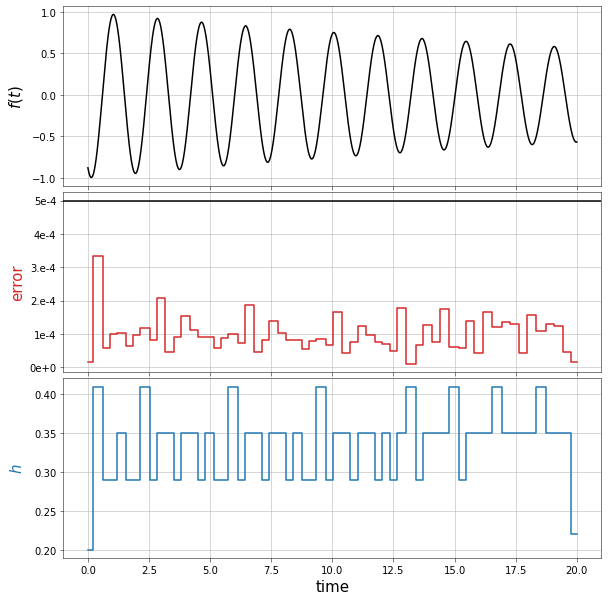

In [10]:
from adaptive.comparison import integrate_env

env.reset(integrator)
_, evals, _, errors = integrate_env(predictor, integrator, env, x0=t0, x1=t1)

# plot the time-stepping
from adaptive.plots import plot_trajectory_quad
fig, ax = plot_trajectory_quad(nodes=env.nodes,
                                f=env.fun,
                                errors=env.errors,
                                deltas=env.deltas,
                                error_tolerance=env.error_tol,
                                figsize=(8, 8),
                                linewidth=1.5,
                                axislabelsize=15,
                                ticklabelsize=10)

Now we will compare the performance of our NN step size predictor to the equidistant Simpson's rule. In order to approximate the average performance of the NN, we have to sample the function space thoroughly, which can take a minute or two. (If the execution of the next block takes a lot of time on your machine, you can reduce `num_samples`.)

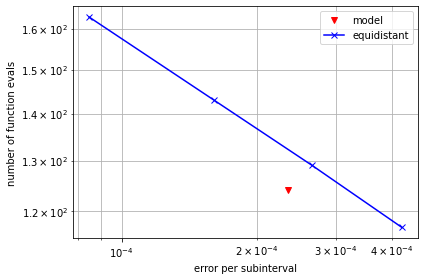

In [11]:
num_samples = 300  # number of functions to sample from the class

# performance NN
errors = []
evals = []
for i in range(num_samples):
    env.reset(integrator)
    _, _, _, err = integrate_env(predictor, integrator, env, t0, t1)
    errors.append(np.mean(err))
    evals.append((len(env.nodes) - 1) * 2 + 1)

perf_model = np.array([np.mean(errors), np.mean(evals)])

# performance equidistant
from adaptive.predictor import PredictorConst  # predictor that always chooses step size h (equidistant)
step_s = np.linspace(0.25, 0.35, 4)  # step sizes for equidistant Simpson's rule
perf_eq = []

for h in step_s:
    predictor_const = PredictorConst(h)  
    errors = []
    evals = []
    for _ in range(num_samples):
        env.reset(integrator)
        _, _, _, err = integrate_env(predictor_const, integrator, env, t0, t1)
        errors.append(np.mean(err))
        evals.append((len(env.nodes) - 1) * 2 + 1)
        
    perf_eq.append([np.mean(errors), np.mean(evals)])
perf_eq = np.array(perf_eq)

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_model[0], perf_model[1], 'rv', label='model')
plt.loglog(perf_eq[:, 0], perf_eq[:, 1], 'bx-', label='equidistant')
plt.legend()
plt.xlabel('error per subinterval')
plt.ylabel('number of function evals')
plt.grid(which='both')
plt.tight_layout()
plt.show()


A quadrature rule is a weighted sum of function evaluation at given nodes. Rather than continuing using Simpson's rule, we optimize the weights of a general quadrature rule with 3 equidistant nodes for the given problem class such that the new quadrature rule combined with our NN time-stepper behaves optimally.
For this, we acquire training data by sampling and integrating functions from the class using the NN adaptive time stepper. Then we use a scikit-learn `LinearRegression` to optimize the weights for each of the step sizes in `step_sizes`. If the data acquisition takes too long on your machine, you can reduce `num_episodes`, but be aware that this may result in worse weights.

In [12]:
# acquire training data
num_episodes = 100  # number of functions to sample and integrate

num_step_sizes = len(step_sizes)
states = [[] for _ in range(num_step_sizes)]  # states[i] is a list of states with the i_th step_size
integrals = [[] for _ in range(num_step_sizes)]  # integrals[i] is a list with the associated correct integrals

for episode in range(num_episodes):
    state = env.reset(integrator)
    done = False

    while not done:
        step_size = predictor(state)
        next_state, reward, done, info = env.iterate(step_size, integrator)

        f_evals = next_state[0][1:]
        step_size_idx = np.argwhere(np.isclose(predictor.step_sizes, step_size))[0, 0]
        states[step_size_idx].append(f_evals)
        integrals[step_size_idx].append(info["correct_integral"])
        state = next_state.copy()

In [13]:
# optimize weights using linear regression
from sklearn.linear_model import LinearRegression

models = []
for step_size_idx in range(len(step_sizes)):
    print("{} samples for step_size {}".format(len(states[step_size_idx]), np.round(step_sizes[step_size_idx], 2)))
    step_size = step_sizes[step_size_idx]

    if len(states[step_size_idx]) < 100:
        # there are not enough samples for a reliable calculation -> choose simpson
        print("Not enough samples, default to Simpson's rule.")
        model = LinearRegression()
        weights = step_size * np.array([1, 4, 1]) / 6
        model.coef_ = weights
        model.intercept_ = np.zeros((1,))
    
    else:
        X = np.stack(states[step_size_idx])
        y = np.array(integrals[step_size_idx])
        model = LinearRegression().fit(X, y)

        # disregard the 10% of worst data and fit again
        pred = model.predict(X)
        error = np.abs(y - pred)
        ind = error.argsort()[-(len(error) // 10):][::-1]
        X = np.delete(X, ind, axis=0)
        y = np.delete(y, ind)
        model = LinearRegression().fit(X, y)
    models.append(model)

    print("weights: {}".format(model.coef_))
    print("intercept: {}".format(model.intercept_))
    print('')

0 samples for step_size 0.2
Not enough samples, default to Simpson's rule.
weights: [0.03333333 0.13333333 0.03333333]
intercept: [0.]

0 samples for step_size 0.23
Not enough samples, default to Simpson's rule.
weights: [0.03833333 0.15333333 0.03833333]
intercept: [0.]

262 samples for step_size 0.26
weights: [0.0448838  0.17061188 0.04487667]
intercept: -8.859124410454111e-08

2380 samples for step_size 0.29
weights: [0.05015994 0.19013395 0.05014438]
intercept: -1.1532668645012484e-06

0 samples for step_size 0.32
Not enough samples, default to Simpson's rule.
weights: [0.05333333 0.21333333 0.05333333]
intercept: [0.]

2617 samples for step_size 0.35
weights: [0.06136085 0.22824724 0.06135244]
intercept: -3.0263771902700604e-06

180 samples for step_size 0.38
weights: [0.045973   0.28984446 0.03924831]
intercept: 0.0037642804712266498

623 samples for step_size 0.41
weights: [0.054045   0.28734706 0.05362149]
intercept: -0.0003809073111376419

0 samples for step_size 0.44
Not enou

In [14]:
# build integrator with optimized weights
from adaptive.integrator import IntegratorLinReg
integrator = IntegratorLinReg(step_sizes, models, integrator)

Finally, we evaluate the performance of the model with optimized weights. The average number of function evaluations should be the same as before, but we expect the average error to be smaller than when using the ordinary Simpson's rule.

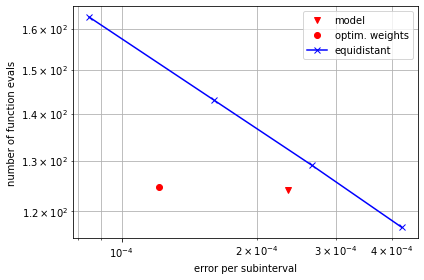

In [15]:
num_samples = 300 # number of functions to sample from the class

# performance NN with optimized weights
errors = []
evals = []
for i in range(num_samples):
    env.reset(integrator)
    _, _, _, err = integrate_env(predictor, integrator, env, t0, t1)
    errors.append(np.mean(err))
    evals.append((len(env.nodes) - 1) * 2 + 1)

perf_model_weights = np.array([np.mean(errors), np.mean(evals)])

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_model[0], perf_model[1], 'rv', label='model')
plt.loglog(perf_model_weights[0], perf_model_weights[1], 'ro', label='optim. weights')
plt.loglog(perf_eq[:, 0], perf_eq[:, 1], 'bx-', label='equidistant')
plt.legend()
plt.xlabel('error per subinterval')
plt.ylabel('number of function evals')
plt.grid(which='both')
plt.tight_layout()
plt.show()